In [1]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

import os
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#Set a random state
rs = 4

#Set our CVs
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)
cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=rs)

#Set the scaler
scaler = PowerTransformer()

In [2]:
#Get current directory 
path = os.getcwd() 

#Get parent directory 
parent = os.path.dirname(path)

#Move to the directory with data
train_csv = os.path.join(parent, "data", "train.csv")

#Import our dataset
dataset = pd.read_csv(train_csv, delimiter = '|')

#Clean the dataset (drop unrealistic entries)
dataset_org = dataset.copy()
dataset = dataset[dataset['scannedLineItemsPerSecond'] < 4]
cutted = len(dataset_org)-len(dataset)
print(f"{cutted} entries removed due to errors in feature 'scannedLineItemsPerSecond'.")

#Add new feature 'totalItems'
dataset = dataset.assign(totalItems = dataset.totalScanTimeInSeconds * dataset.scannedLineItemsPerSecond)

#Add new feature 'suspicious' as frauds only occur at trustLevels 1-2, all others are non-fraudulent
suspicious = dataset['trustLevel'].copy()
suspicious[suspicious > 2] = 3
dataset = dataset.assign(suspicious = suspicious)

#Drop 'trustLevel' as it is too similar to 'suspicious'
dataset = dataset.drop("trustLevel", axis=1)

#Add new feature 'avgLineItemValue'
dataset = dataset.assign(avgLineItemValue = dataset.valuePerSecond / dataset.scannedLineItemsPerSecond)

4 entries removed due to errors in feature 'scannedLineItemsPerSecond'.


In [3]:
#Split the dataset in X and y
X = dataset.drop('fraud', axis=1)
y = dataset.fraud

In [4]:
X.head()

,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalItems,avgLineItemValue,suspicious
0,1054,54.70,7,0,3,0.027514,0.051898,0.241379,29.0,1.886207,3
1,108,27.36,5,2,4,0.129630,0.253333,0.357143,14.0,1.954286,3
2,1516,62.16,3,10,5,0.008575,0.041003,0.230769,13.0,4.781538,3
3,1791,92.31,8,4,4,0.016192,0.051541,0.275862,29.0,3.183103,3
4,430,81.53,3,7,2,0.062791,0.189605,0.111111,27.0,3.019630,3


In [5]:
#Define monetary_score as our used metric
def monetary_score_func(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    monetary_value = (cm[0,0] * 0) + (cm[1, 0] * -5) + (cm[0, 1] * -25) + (cm[1, 1] * 5)
    max_monetary_value = (cm[1,0] + cm[1,1]) * 5
    return (monetary_value / max_monetary_value)

monetary_score = make_scorer(monetary_score_func)

In [6]:
#Define models and parameters
model_LR = LogisticRegression(random_state=rs, n_jobs=-1)
params_LR = {
    "model__solver": ["liblinear", "lbfgs"],
    "model__class_weight": [None, "balanced"],
    "model__C": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
            }

model_XG = XGBClassifier(booster="gblinear", random_state=rs, n_jobs=-1)
params_XG = {
    "model__eta": [0.01, 0.02, 0.03],
    "model__n_estimators": [1000, 1500, 2000],
    "model__lambda": [0, 0.001, 0.002, 0.003],
    "model__alpha": [0, 0.0001, 0.0005, 0.00075, 0.001]
            }

model_mlp = MLPClassifier(max_iter=500, random_state=rs)
params_mlp = {
          'model__hidden_layer_sizes':[(8,4), (8,4,2)],
          'model__learning_rate_init':[0.001, 0.005],
          'model__alpha':[1.3, 1.4, 1.5] 
             }

model_svc = SVC(kernel="linear", random_state=rs)
params_svc = {"model__C": [0.08, 0.09, 0.1, 0.11, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

model_ada = BaggingClassifier(base_estimator=AdaBoostClassifier(), random_state=rs, n_jobs=-1)
params_ada = {
    "model__bootstrap": [True, False],
    "model__max_samples": [0.25, 0.5, 0.75, 1.0],
    "model__n_estimators": [5, 10, 25, 50]
             }

Model	 Score		 2STD
LogReg	 0.624286	 0.462747
XG	 0.578095	 0.388478
MLP	 0.565714	 0.503751
SVC	 0.499048	 0.445503
Ada	 0.462381	 0.368811


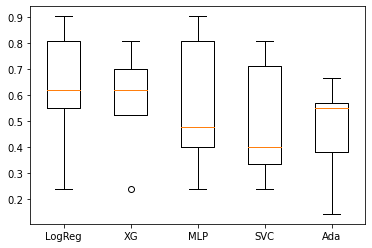

In [7]:
#Get the models together
results = []
names = []

models = []
models.append(("LogReg", model_LR, params_LR))
models.append(("XG", model_XG, params_XG))
models.append(("MLP", model_mlp, params_mlp))
models.append(("SVC", model_svc, params_svc))
models.append(("Ada", model_ada, params_ada))

print("Model\t Score\t\t 2STD")

for name, model, params in models:
    pipe_model = Pipeline([
        ("scaler", scaler),
        ("model", model)
    ])
    
    grid = GridSearchCV(estimator=pipe_model, param_grid=params, scoring=monetary_score, cv=cv_inner, n_jobs=-1)
    nested_cv = cross_validate(estimator=grid, X=X, y=y, cv=cv_outer, scoring=monetary_score, n_jobs=-1)
    results.append(nested_cv["test_score"])
    names.append(name)
    print("%s\t %f\t %f" % (name, nested_cv["test_score"].mean(), nested_cv["test_score"].std()*2))
    
#Boxplot nested scores
boxplot_nested = plt.boxplot(results, labels=names)

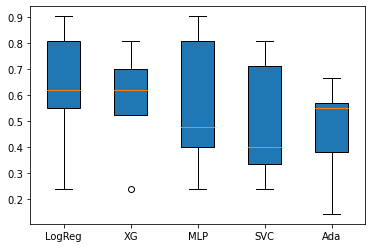

In [8]:
boxplot_nested = plt.boxplot(results, labels=names, vert=True, patch_artist=True)

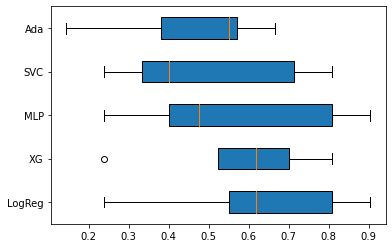

In [9]:
boxplot_nested = plt.boxplot(results, labels=names, vert=False, patch_artist=True)